In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/AML _Final_report')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from keras import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Input, Bidirectional, RepeatVector, Concatenate, Activation
from keras.layers import BatchNormalization,Dropout
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import lightgbm as lgb
import time
from sklearn.ensemble import HistGradientBoostingRegressor

In [3]:
train = pd.read_csv('processed_train.csv')
train.drop(columns = ['Unnamed: 0'], inplace = True)
y = pd.read_csv('label_train.csv')
y = y['revenue']
test = pd.read_csv('processed_test.csv')
test.drop(columns = ['Unnamed: 0'], inplace = True)

Neural Network

In [ ]:
NN_model = Sequential()

NN_model.add(Dense(64, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                14912     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17,025
Trainable params: 17,025
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
# checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
# callbacks_list = [checkpoint]

In [ ]:
test.fillna(test.mode().iloc[0], inplace = True)

In [ ]:
# NN
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)

    
preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

for j in tqdm(range(k)):   
    x_train = train.loc[list_of_train_index[j], :]
    x_valid = train.loc[list_of_valid_index[j], :]
    
    y_true_train = np.array(y[list_of_train_index[j]])
    y_true_valid = np.array(y[list_of_valid_index[j]])
    # print(type(y_true_train))
    # print(x_train.shape)
    # print(type(x_train))
    # # print(np.)
    # print(x_valid.shape)
    # print(test.shape)
    # print('--------------')
    NN_model = Sequential()

    NN_model.add(Dense(64, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu'))
    # NN_model.add(Dropout(0.5))
    # NN_model.add(BatchNormalization())
    # The Hidden Layers :
    NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))
    # NN_model.add(BatchNormalization())
    # NN_model.add(Dense(32, kernel_initializer='normal',activation='relu'))


    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

    # Compile the network :
    NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    NN_model.fit(x_train,y_true_train, epochs=10, batch_size=100)
    preds_train[:,j] = NN_model.predict(train).reshape(train.shape[0],)
    preds_val[:,j] = NN_model.predict(x_valid).reshape(x_valid.shape[0],)
    preds_test[:,j] = NN_model.predict(test).reshape(test.shape[0],)
    
    log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
    log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
final_preds_lgb = preds_test.mean(axis=1)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
27/27 [==============================] - 1s 6ms/step - loss: 225.7565 - mean_squared_error: 225.7565
Epoch 2/10
27/27 [==============================] - 0s 6ms/step - loss: 14.6556 - mean_squared_error: 14.6556
Epoch 3/10
27/27 [==============================] - 0s 4ms/step - loss: 9.4178 - mean_squared_error: 9.4178
Epoch 4/10
27/27 [==============================] - 0s 5ms/step - loss: 8.8643 - mean_squared_error: 8.8643
Epoch 5/10
27/27 [==============================] - 0s 5ms/step - loss: 8.5632 - mean_squared_error: 8.5632
Epoch 6/10
27/27 [==============================] - 0s 5ms/step - loss: 8.4147 - mean_squared_error: 8.4147
Epoch 7/10
27/27 [==============================] - 0s 4ms/step - loss: 8.2346 - mean_squared_error: 8.2346
Epoch 8/10
27/27 [==============================] - 0s 5ms/step - loss: 8.3082 - mean_squared_error: 8.3082
Epoch 9/10
27/27 [==============================] - 0s 5ms/step - loss: 8.4556 - mean_squared_error: 8.4556
Epoch 10/10
27/27 [===

 10%|█         | 1/10 [00:04<00:42,  4.74s/it]

Epoch 1/10
27/27 [==============================] - 1s 3ms/step - loss: 54.4323 - mean_squared_error: 54.4323
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 9.7280 - mean_squared_error: 9.7280
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 8.9208 - mean_squared_error: 8.9208
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 8.5131 - mean_squared_error: 8.5131
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 8.3326 - mean_squared_error: 8.3326
Epoch 6/10
27/27 [==============================] - 0s 3ms/step - loss: 8.1612 - mean_squared_error: 8.1612
Epoch 7/10
27/27 [==============================] - 0s 3ms/step - loss: 8.0983 - mean_squared_error: 8.0983
Epoch 8/10
27/27 [==============================] - 0s 3ms/step - loss: 8.2546 - mean_squared_error: 8.2546
Epoch 9/10
27/27 [==============================] - 0s 4ms/step - loss: 7.7835 - mean_squared_error: 7.7835
Epoch 10/10
27/27 [=======

 20%|██        | 2/10 [00:07<00:29,  3.74s/it]

Epoch 1/10
27/27 [==============================] - 1s 3ms/step - loss: 650.6415 - mean_squared_error: 650.6415
Epoch 2/10
27/27 [==============================] - 0s 3ms/step - loss: 21.3245 - mean_squared_error: 21.3245
Epoch 3/10
27/27 [==============================] - 0s 3ms/step - loss: 9.4493 - mean_squared_error: 9.4493
Epoch 4/10
27/27 [==============================] - 0s 3ms/step - loss: 8.8404 - mean_squared_error: 8.8404
Epoch 5/10
27/27 [==============================] - 0s 3ms/step - loss: 8.8146 - mean_squared_error: 8.8146
Epoch 6/10
27/27 [==============================] - 0s 3ms/step - loss: 8.7141 - mean_squared_error: 8.7141
Epoch 7/10
27/27 [==============================] - 0s 3ms/step - loss: 8.2994 - mean_squared_error: 8.2994
Epoch 8/10
27/27 [==============================] - 0s 3ms/step - loss: 8.2860 - mean_squared_error: 8.2860
Epoch 9/10
27/27 [==============================] - 0s 5ms/step - loss: 8.0597 - mean_squared_error: 8.0597
Epoch 10/10
27/27 [===

 30%|███       | 3/10 [00:10<00:22,  3.19s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 42.1456 - mean_squared_error: 42.1456
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 9.8080 - mean_squared_error: 9.8080
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 8.9772 - mean_squared_error: 8.9772
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 9.1803 - mean_squared_error: 9.1803
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 10.3007 - mean_squared_error: 10.3007
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 10.9230 - mean_squared_error: 10.9230
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 8.7988 - mean_squared_error: 8.7988
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 7.8009 - mean_squared_error: 7.8009
Epoch 9/10
27/27 [==============================] - 0s 3ms/step - loss: 7.8513 - mean_squared_error: 7.8513
Epoch 10/10
27/27 [===

 40%|████      | 4/10 [00:12<00:16,  2.80s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 28.5684 - mean_squared_error: 28.5684
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 9.3056 - mean_squared_error: 9.3056
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 9.1464 - mean_squared_error: 9.1464
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 8.6465 - mean_squared_error: 8.6465
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 8.2277 - mean_squared_error: 8.2277
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 8.0980 - mean_squared_error: 8.0980
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 8.4691 - mean_squared_error: 8.4691
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 8.5617 - mean_squared_error: 8.5617
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 8.0622 - mean_squared_error: 8.0622
Epoch 10/10
27/27 [=======

 50%|█████     | 5/10 [00:13<00:11,  2.32s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 484.1562 - mean_squared_error: 484.1562
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 35.2008 - mean_squared_error: 35.2008
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 11.1151 - mean_squared_error: 11.1151
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 8.8593 - mean_squared_error: 8.8593
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 8.5502 - mean_squared_error: 8.5502
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 8.3603 - mean_squared_error: 8.3603
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 8.1898 - mean_squared_error: 8.1898
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 8.1002 - mean_squared_error: 8.1002
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 8.0386 - mean_squared_error: 8.0386
Epoch 10/10
27/27 [=

 60%|██████    | 6/10 [00:15<00:08,  2.05s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 45.5539 - mean_squared_error: 45.5539
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 9.4617 - mean_squared_error: 9.4617
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 8.6178 - mean_squared_error: 8.6178
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 8.2914 - mean_squared_error: 8.2914
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 8.8914 - mean_squared_error: 8.8914
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 8.3594 - mean_squared_error: 8.3594
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 7.8574 - mean_squared_error: 7.8574
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 7.6413 - mean_squared_error: 7.6413
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 8.0301 - mean_squared_error: 8.0301
Epoch 10/10
27/27 [=======

 70%|███████   | 7/10 [00:16<00:05,  1.86s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 83.3553 - mean_squared_error: 83.3553
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 14.1608 - mean_squared_error: 14.1608
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 8.9737 - mean_squared_error: 8.9737
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 8.4687 - mean_squared_error: 8.4687
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 8.3352 - mean_squared_error: 8.3352
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 8.1393 - mean_squared_error: 8.1393
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 7.9921 - mean_squared_error: 7.9921
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 7.8758 - mean_squared_error: 7.8758
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 7.8587 - mean_squared_error: 7.8587
Epoch 10/10
27/27 [=====

 80%|████████  | 8/10 [00:18<00:03,  1.73s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 82.9082 - mean_squared_error: 82.9082
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 11.1818 - mean_squared_error: 11.1818
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 8.3846 - mean_squared_error: 8.3846
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 8.0868 - mean_squared_error: 8.0868
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 7.8548 - mean_squared_error: 7.8548
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 7.6226 - mean_squared_error: 7.6226
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 7.6057 - mean_squared_error: 7.6057
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 7.7070 - mean_squared_error: 7.7070
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 7.3166 - mean_squared_error: 7.3166
Epoch 10/10
27/27 [=====

 90%|█████████ | 9/10 [00:19<00:01,  1.66s/it]

Epoch 1/10
27/27 [==============================] - 0s 2ms/step - loss: 65.0427 - mean_squared_error: 65.0427
Epoch 2/10
27/27 [==============================] - 0s 2ms/step - loss: 11.0396 - mean_squared_error: 11.0396
Epoch 3/10
27/27 [==============================] - 0s 2ms/step - loss: 9.0475 - mean_squared_error: 9.0475
Epoch 4/10
27/27 [==============================] - 0s 2ms/step - loss: 8.8322 - mean_squared_error: 8.8322
Epoch 5/10
27/27 [==============================] - 0s 2ms/step - loss: 8.5734 - mean_squared_error: 8.5734
Epoch 6/10
27/27 [==============================] - 0s 2ms/step - loss: 8.6631 - mean_squared_error: 8.6631
Epoch 7/10
27/27 [==============================] - 0s 2ms/step - loss: 8.4839 - mean_squared_error: 8.4839
Epoch 8/10
27/27 [==============================] - 0s 2ms/step - loss: 8.3099 - mean_squared_error: 8.3099
Epoch 9/10
27/27 [==============================] - 0s 2ms/step - loss: 8.1755 - mean_squared_error: 8.1755
Epoch 10/10
27/27 [=====

100%|██████████| 10/10 [00:21<00:00,  2.14s/it]


In [ ]:
np.mean(log_rmse_train)

2.763757030782901

In [ ]:
np.mean(log_rmse_val)

2.768222144866415

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub.revenue = np.exp(final_preds_lgb)
sub.to_csv('sub_NN3.csv',index=False)
sub

,id,revenue
0,3001,4.520913e+06
1,3002,3.469366e+06
2,3003,8.187650e+06
3,3004,2.047239e+07
4,3005,5.209558e+06
...,...,...
4393,7394,9.583094e+06
4394,7395,4.710043e+07
4395,7396,1.197763e+07
4396,7397,7.979318e+06


Linear Regression

In [ ]:
train = pd.read_csv('processed_train.csv')
train.drop(columns = ['Unnamed: 0'], inplace = True)
y = pd.read_csv('label_train.csv')
y = y['revenue']
test = pd.read_csv('processed_test.csv')
test.drop(columns = ['Unnamed: 0'], inplace = True)

In [6]:
test.fillna(test.mode().iloc[0], inplace = True)
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
k=10
kf = KFold(n_splits=k,
            shuffle=True,
            random_state=int(time.time()))

list_of_train_index = []
list_of_valid_index = []

for train_index, valid_index in kf.split(np.zeros(len(y)), # Placeholder (dummy input)
                                          y): # True input
    
    list_of_train_index.append(train_index)
    list_of_valid_index.append(valid_index)


preds_train = np.zeros([len(train),k])
preds_val = np.zeros([len(list_of_valid_index[0]),k])
preds_test = np.zeros([len(test),k])

log_rmse_train = []
log_rmse_val = []

for j in tqdm(range(k)):   
    x_train = train.loc[list_of_train_index[j], :]
    x_valid = train.loc[list_of_valid_index[j], :]

    #standard_scaler = StandardScaler()
    # x_train_sca = standard_scaler.fit_transform(x_train)
    # x_valid_sca = standard_scaler.transform(x_valid)
    # x_test_sca = standard_scaler.transform(test)

    y_true_train = y[list_of_train_index[j]]
    y_true_valid = y[list_of_valid_index[j]]

    LR = LinearRegression()
    LR.fit(x_train,y_true_train)
    preds_train[:,j] = LR.predict(train)
    preds_val[:,j] = LR.predict(x_valid)
    preds_test[:,j] = LR.predict(test)
    
    log_rmse_train.append(np.sqrt(mse(preds_train[:,j],y)))
    log_rmse_val.append(np.sqrt(mse(preds_val[:,j],y_true_valid)))
final_preds = preds_test.mean(axis=1)

100%|██████████| 10/10 [00:03<00:00,  2.99it/s]


In [7]:
np.mean(log_rmse_train)

2.187451740155463

In [8]:
np.mean(log_rmse_val)

2.351295155384916

In [10]:
sub = pd.read_csv('sample_submission.csv')
sub.revenue = np.exp(final_preds)
sub.to_csv('sub_LR.csv',index=False)
sub

,id,revenue
0,3001,3.071147e+07
1,3002,4.641879e+05
2,3003,4.585603e+06
3,3004,3.699388e+06
4,3005,1.333989e+05
...,...,...
4393,7394,3.687311e+07
4394,7395,3.721475e+07
4395,7396,1.386875e+07
4396,7397,1.544049e+06


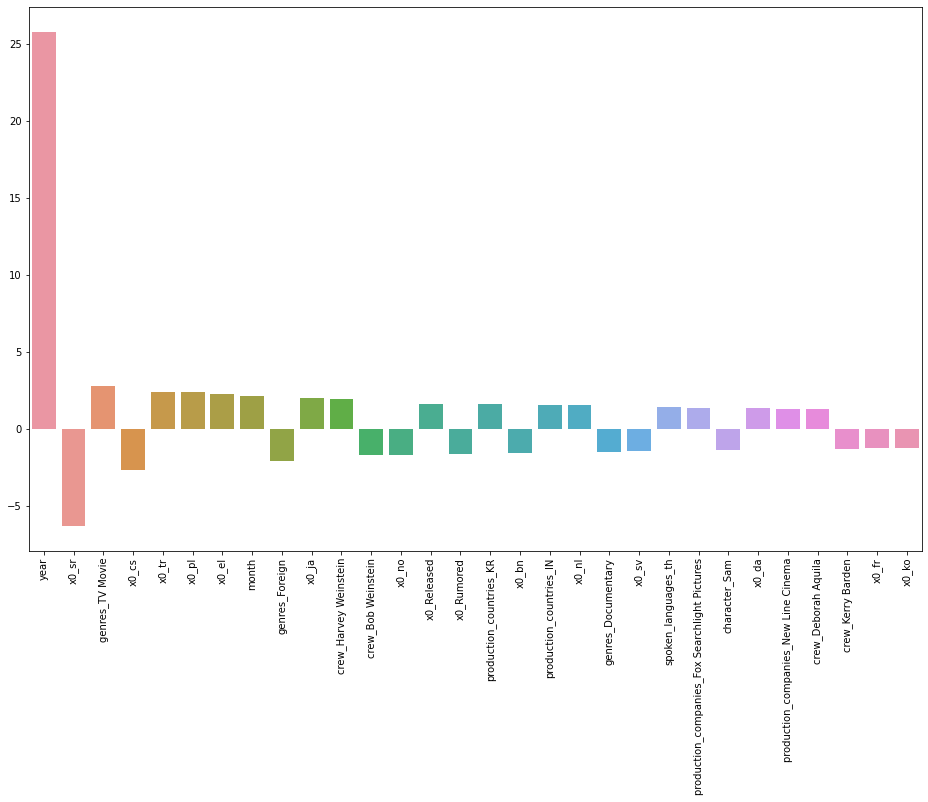

In [9]:
coef = LR.coef_
feature = LR.feature_names_in_
coef_feature = zip(coef,feature)
sort_coef = sorted(coef_feature,key = lambda x: abs(x[0]),reverse=True)[:30]
res = list(zip(*sort_coef))
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize = (16,10))
ax = sns.barplot(x = list(res[1]),y = list(res[0]))
ax.tick_params(axis = 'x',rotation = 90)